# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(degrees=(20, -20), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
'''
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
'''

"\n# We'd need to convert it into Numpy! Remember above we have converted it into tensors already\ntrain_data = train.train_data\ntrain_data = train.transform(train_data.numpy())\n\nprint('[Train]')\nprint(' - Numpy Shape:', train.train_data.cpu().numpy().shape)\nprint(' - Tensor Shape:', train.train_data.size())\nprint(' - min:', torch.min(train_data))\nprint(' - max:', torch.max(train_data))\nprint(' - mean:', torch.mean(train_data))\nprint(' - std:', torch.std(train_data))\nprint(' - var:', torch.var(train_data))\n\ndataiter = iter(train_loader)\nimages, labels = dataiter.next()\n\nprint(images.shape)\nprint(labels.shape)\n\n# Let's visualize some of the images\n%matplotlib inline\nimport matplotlib.pyplot as plt\n\nplt.imshow(images[0].numpy().squeeze(), cmap='gray_r')\n"

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
'''
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
'''

"\nfigure = plt.figure()\nnum_of_images = 60\nfor index in range(1, num_of_images + 1):\n    plt.subplot(6, 10, index)\n    plt.axis('off')\n    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')\n"

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0), nn.ReLU()) #   # output_size = 26      
        self.bnrm1 = nn.Sequential(nn.BatchNorm2d(16))
        self.drop1 = nn.Sequential(nn.Dropout2d(0.1)) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), nn.ReLU())## output_size = 24
        self.bnrm2 = nn.Sequential(nn.BatchNorm2d(32))
        self.drop2 = nn.Sequential(nn.Dropout2d(0.1))

        # TRANSITION BLOCK 1
        self.pool1 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2)) # output_size = 12      
        
        self.conv3 = nn.Sequential(nn.Conv2d(32, 10, kernel_size=1, stride=1, padding=0), nn.ReLU()) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.conv4 = nn.Sequential(nn.Conv2d(10, 64, kernel_size=3, stride=1, padding=0), nn.ReLU())# # output_size = 10
        self.bnrm3 = nn.Sequential(nn.BatchNorm2d(64))
        self.drop3 = nn.Sequential(nn.Dropout2d(0.1))
      
        # TRANSITION BLOCK 2
        self.pool2 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2)) # output_size = 5        
       
        self.conv5 = nn.Sequential(nn.Conv2d(64, 10, kernel_size=1, stride=1, padding=0)) #  # output_size = 5
        
                
        # OUTPUT BLOCK
        self.conv6 = nn.Sequential(nn.Conv2d(10, 10, kernel_size=5, stride=1, padding=0))# nn.ReLU() NEVER!  output_size = 1
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bnrm1(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.bnrm2(x)
        x = self.drop2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bnrm3(x)
        x = self.drop3(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.reshape(x.size(0), -1)
        return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,640
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
         Dropout2d-8           [-1, 32, 24, 24]               0
         MaxPool2d-9           [-1, 32, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             330
             ReLU-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 64, 10, 10]           5,824
             ReLU-13           [-1, 64, 10, 10]               0
      BatchNorm2d-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
'''
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 30
for epoch in range(EPOCHS):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
'''

"\nfrom torch.optim.lr_scheduler import StepLR\nmodel =  Net().to(device)\noptimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)\nscheduler = StepLR(optimizer, step_size=6, gamma=0.1)\nEPOCHS = 30\nfor epoch in range(EPOCHS):\n    # Decay Learning Rate\n    scheduler.step()\n    # Print Learning Rate\n    print('Epoch:', epoch,'LR:', scheduler.get_lr())\n    train(model, device, train_loader, optimizer, epoch)\n    test(model, device, test_loader)\n"

In [0]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 50
for epoch in range(EPOCHS):
    # Decay Learning Rate
    scheduler.step()
    # Print Learning Rate
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 0 LR: [0.03]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.013952975161373615 Batch_id=468 Accuracy=93.81: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9855/10000 (98.55%)

Epoch: 1 LR: [0.03]


Loss=0.1771380454301834 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9848/10000 (98.48%)

Epoch: 2 LR: [0.03]


Loss=0.20781584084033966 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:13<00:00, 36.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9882/10000 (98.82%)

Epoch: 3 LR: [0.03]


Loss=0.06882894039154053 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9875/10000 (98.75%)

Epoch: 4 LR: [0.03]


Loss=0.020425846800208092 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:12<00:00, 37.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9889/10000 (98.89%)

Epoch: 5 LR: [0.00030000000000000003]


Loss=0.10858762264251709 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:12<00:00, 36.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

Epoch: 6 LR: [0.003]


Loss=0.06224392354488373 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9922/10000 (99.22%)

Epoch: 7 LR: [0.003]


Loss=0.041525404900312424 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

Epoch: 8 LR: [0.003]


Loss=0.0791122242808342 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

Epoch: 9 LR: [0.003]


Loss=0.025937259197235107 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)

Epoch: 10 LR: [0.003]


Loss=0.010109771974384785 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 35.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

Epoch: 11 LR: [3.0000000000000004e-05]


Loss=0.02189825288951397 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

Epoch: 12 LR: [0.00030000000000000003]


Loss=0.04981734976172447 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)

Epoch: 13 LR: [0.00030000000000000003]


Loss=0.005906686186790466 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.36%)

Epoch: 14 LR: [0.00030000000000000003]


Loss=0.08583205193281174 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

Epoch: 15 LR: [0.00030000000000000003]


Loss=0.006680985447019339 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

Epoch: 16 LR: [0.00030000000000000003]


Loss=0.01841413974761963 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 42.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

Epoch: 17 LR: [3.0000000000000005e-06]


Loss=0.020039791241288185 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

Epoch: 18 LR: [3.0000000000000004e-05]


Loss=0.091193288564682 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 19 LR: [3.0000000000000004e-05]


Loss=0.04152686521410942 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 20 LR: [3.0000000000000004e-05]


Loss=0.02543375827372074 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

Epoch: 21 LR: [3.0000000000000004e-05]


Loss=0.004121894482523203 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 22 LR: [3.0000000000000004e-05]


Loss=0.04160091653466225 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

Epoch: 23 LR: [3.000000000000001e-07]


Loss=0.0024370301980525255 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 24 LR: [3.0000000000000005e-06]


Loss=0.01580038107931614 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 25 LR: [3.0000000000000005e-06]


Loss=0.018743207678198814 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

Epoch: 26 LR: [3.0000000000000005e-06]


Loss=0.0064110360108315945 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 27 LR: [3.0000000000000005e-06]


Loss=0.0059190294705331326 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 28 LR: [3.0000000000000005e-06]


Loss=0.01671963930130005 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 29 LR: [3.000000000000001e-08]


Loss=0.023499557748436928 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 30 LR: [3.000000000000001e-07]


Loss=0.014563138596713543 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 34.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 31 LR: [3.000000000000001e-07]


Loss=0.017811765894293785 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 32 LR: [3.000000000000001e-07]


Loss=0.014584963209927082 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

Epoch: 33 LR: [3.000000000000001e-07]


Loss=0.010852545499801636 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 34 LR: [3.000000000000001e-07]


Loss=0.010295202024281025 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9932/10000 (99.32%)

Epoch: 35 LR: [3.0000000000000012e-09]


Loss=0.012226362712681293 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 37.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 36 LR: [3.000000000000001e-08]


Loss=0.02491072379052639 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 37 LR: [3.000000000000001e-08]


Loss=0.059885382652282715 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:12<00:00, 36.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 38 LR: [3.000000000000001e-08]


Loss=0.016475513577461243 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 39 LR: [3.000000000000001e-08]


Loss=0.013292971067130566 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

Epoch: 40 LR: [3.000000000000001e-08]


Loss=0.021495530381798744 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 41 LR: [3.0000000000000015e-10]


Loss=0.043200284242630005 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 42 LR: [3.0000000000000012e-09]


Loss=0.04099166393280029 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

Epoch: 43 LR: [3.0000000000000012e-09]


Loss=0.010005037300288677 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

Epoch: 44 LR: [3.0000000000000012e-09]


Loss=0.023184126242995262 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 45 LR: [3.0000000000000012e-09]


Loss=0.05668002739548683 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 46 LR: [3.0000000000000012e-09]


Loss=0.0031512875575572252 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)

Epoch: 47 LR: [3.000000000000002e-11]


Loss=0.006204868201166391 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9934/10000 (99.34%)

Epoch: 48 LR: [3.0000000000000015e-10]


Loss=0.03373853862285614 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 49 LR: [3.0000000000000015e-10]


Loss=0.005391875747591257 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]



Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

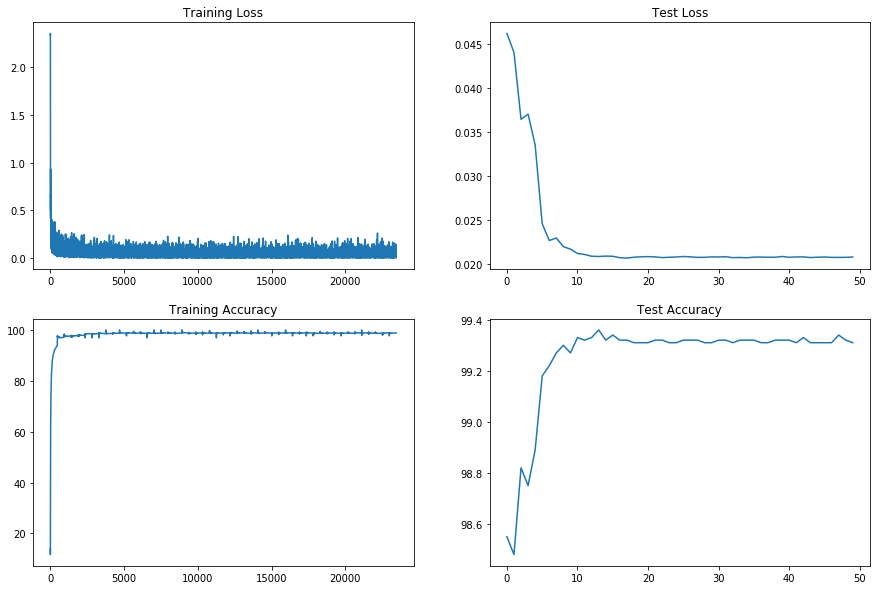

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")